Mount drive to access checkpoints and datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Imports

In [ ]:
from PIL import Image as pimg
import numpy as np
import torch
from torchvision import transforms
import os
import shutil
from tqdm import tqdm
import json
import pandas as pd
import matplotlib.pyplot as plt
import random

# Constants

In [ ]:
clean_dataset = '/content/drive/My Drive/231A Final Project/InfiniteForm/clean_dataset/'

annot = json.load(open("/content/drive/My Drive/231A Final Project/InfiniteForm/clean_annotations.json", "r"))

MPII_JOINT_NAMES = [
    'right_ankle', 'right_knee', 'right_hip', 'left_hip',
    'left_knee', 'left_ankle', 'pelvis', 'spine',
    'neck', 'head_top', 'right_wrist', 'right_elbow',
    'right_shoulder', 'left_shoulder', 'left_elbow', 'left_wrist'
]

skeleton_inf = [[16,14],[14,12],[17,15],[15,13],[12,13],[6,12],[7,13],[6,7],[6,8],[7,9],[8,10],[9,11],[2,3],[1,2],[1,3],[2,4],[3,5],[4,6],[5,7]]
s = np.array(skeleton_inf).flatten()
s = s - 1
skeleton_inf = s.reshape(-1,2)

skeleton_mpii = [[9,8],[8,7],[7,6],[7,12],[7,13],[12,11],[11,10],[13,14], \
                 [14,15],[6,2],[6,3],[2,1],[1,0],[3,4],[4,5]]

WIDTH = 640
HEIGHT = 480

# Helpers

In [ ]:
def evaluate_inf_validation_accuracy(preds, img_idx):
    threshold = 0.5

    pos_gt_src = np.array(annot[img_idx]['keypoints']).reshape(-1, 3)[5:, :-1]
    pos_gt_src = pos_gt_src[[11, 9, 7, 6, 8, 10, 5, 3, 1, 0, 2, 4], :].reshape(1, 12, 2)
    waist_diams = np.linalg.norm(pos_gt_src[0,2,:] - pos_gt_src[0,3,:]).reshape(1, -1)

    preds = np.array(preds).reshape(1, 16, 2)
    preds = preds[:, [0, 1, 2, 3, 4, 5, 10, 11, 12, 13, 14, 15], :]
    preds = np.transpose(preds, [1, 2, 0])
    pos_gt_src = np.transpose(pos_gt_src, [1, 2, 0])

    uv_error = preds - pos_gt_src
    uv_err = np.linalg.norm(uv_error, axis=1)
    
    scale = np.multiply(waist_diams, np.ones((len(uv_err), 1)))
    scaled_uv_err = np.divide(uv_err, scale)
    jnt_count = 12 # CHANGE IF ANYTHING CHANGES
    less_than_threshold = (scaled_uv_err < threshold)
    return less_than_threshold

In [ ]:
def visualize_infinite_form_format(pred, gt, img_path):
  img = pimg.open(img_path)
  plt.figure(figsize=(16,12))
  plt.imshow(img)
  plt.axis('off')

  plt.scatter(pred[:,0], pred[:,1], color='blue', marker='.', label='Predictions')
  plt.scatter(gt[5:,0], gt[5:,1], color='orange', marker='.', label='Ground Truth')

  # GT lines
  for l in skeleton_inf:
    p1, p2 = l
    if p1 in [0,1,2,3,4] or p2 in [0,1,2,3,4]:
      continue
    x = [gt[p1,0],gt[p2,0]]
    y = [gt[p1,1],gt[p2,1]]
    plt.plot(x,y, color='orange')

  # Pred lines
  for l in skeleton_inf:
    p1, p2 = l
    if p1 in [0,1,2,3,4] or p2 in [0,1,2,3,4]:
      continue
    x = [pred[p1-5,0],pred[p2-5,0]]
    y = [pred[p1-5,1],pred[p2-5,1]]
    plt.plot(x,y, color='blue')

  plt.legend()
  plt.title(img_path.split('/')[-1])
  plt.show()

In [ ]:
def visualize_prediction(pred, img_path):
  img = pimg.open(img_path)
  plt.figure(figsize=(16,12))
  plt.imshow(img)
  plt.axis('off')

  plt.scatter(pred[:,0], pred[:,1], color='cyan', marker='.')

  # Pred lines
  for l in skeleton_mpii:
    p1, p2 = l
    x = [pred[p1,0],pred[p2,0]]
    y = [pred[p1,1],pred[p2,1]]
    plt.plot(x,y, color='cyan')

  plt.show()

# Environment Setup

In [ ]:
! git clone https://github.com/anibali/pytorch-stacked-hourglass.git

# Run on MPII

Download MPII dataset

In [ ]:
%cd data/MPII/
! mkdir images
%cd images
! wget https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1.tar.gz
! tar -xvzf data/MPII/images/mpii_human_pose_v1.tar.gz -C data/MPII/

Evaluation

In [ ]:
! python src/evaluate_mpii.py --arch=hg2 --image-path=../imgs/images

In [ ]:
! python src/evaluate_mpii.py --arch=hg8 --image-path=../imgs/images

# Run on InfiniteForm
#### (InfiniteForm clean version, 2647 Images)

Import modules

In [ ]:
%cd /content/pytorch-stacked-hourglass/src/
from stacked_hourglass.model import hg1, hg2, hg8
from stacked_hourglass.predictor import HumanPosePredictor

In [ ]:
predictor_8 = HumanPosePredictor(hg8(pretrained=True), device='cuda')
pcks_8 = []
inf_form_filenames = []

random.seed(5)
files_to_analyze = os.listdir(clean_dataset)
random.shuffle(files_to_analyze)

for img_name in tqdm(files_to_analyze[:250]):
  img_path = os.path.join(clean_dataset, img_name)
  img = pimg.open(img_path)
  convert_tensor = transforms.ToTensor()
  img_tensor = convert_tensor(img)

  joints_8 = predictor_8.estimate_joints(img_tensor, flip=True)

  idx = str(int(img_name.split(".")[0]))

  col = []
  for j in MPII_JOINT_NAMES:
    col.append(j + '_x')
    col.append(j + '_y')

  d = dict(zip(col, joints_8.numpy().flatten()))
  d = pd.DataFrame(d, index=[0])
  # d.to_csv('/content/drive/My Drive/231A Final Project/InfiniteForm/hourglass_predictions/hg8/' + img_name.split(".")[0] + '_coordinates.csv')
  
  pck_8 = evaluate_inf_validation_accuracy(joints_8, idx)
  pcks_8.append(pck_8)

  inf_form_filenames.append(str(int(img_name.split(".")[0])))

Predict using HG2

In [ ]:
predictor_2 = HumanPosePredictor(hg2(pretrained=True), device='cuda')
pcks_2 = []

for img_name in tqdm(files_to_analyze[:250]):
  img_path = os.path.join(clean_dataset, img_name)
  img = pimg.open(img_path)
  convert_tensor = transforms.ToTensor()
  img_tensor = convert_tensor(img)

  joints_2 = predictor_2.estimate_joints(img_tensor, flip=True)

  idx = str(int(img_name.split(".")[0]))

  col = []
  for j in MPII_JOINT_NAMES:
    col.append(j + '_x')
    col.append(j + '_y')

  d = dict(zip(col, joints_2.numpy().flatten()))
  d = pd.DataFrame(d, index=[0])
  # d.to_csv('/content/drive/My Drive/231A Final Project/InfiniteForm/hourglass_predictions/hg2/' + img_name.split(".")[0] + '_coordinates.csv')
  
  pck_2 = evaluate_inf_validation_accuracy(joints_2, idx)
  pcks_2.append(pck_2)

Output PCK metrics

In [ ]:
s, e, w, h, k, a, mm = [], [], [], [], [], [], []

for p in pcks_8:
  shoulder = p[[0,1]]
  elbow = p[[2,3]]
  wrist = p[[4,5]]
  hip = p[[6,7]]
  knee = p[[8,9]]
  ankle = p[[10,11]]

  s.append(shoulder)
  e.append(elbow)
  w.append(wrist)
  h.append(hip)
  k.append(knee)
  a.append(ankle)
  mm.append(np.mean(p))

s = np.round(np.mean(np.array(s).flatten()),2)
e = np.round(np.mean(np.array(e).flatten()),2)
w = np.round(np.mean(np.array(w).flatten()),2)
h = np.round(np.mean(np.array(h).flatten()),2)
k = np.round(np.mean(np.array(k).flatten()),2)
a = np.round(np.mean(np.array(a).flatten()),2)

m = np.round(np.mean([s,e,w,h,k,a]),2)

print('Max: ' + str(max(mm)) + '\n' + 'Filename: ' + inf_form_filenames[np.argmax(mm)] + '\n')

print('Final validation PCK scores HG8:' + '\n')
print('Shoulder    Elbow    Wrist    Hip    Knee    Ankle    Mean')
print('--------    -----    -----    ---    ----    -----    ----')
print('  ' + str(s) + '       ' + str(e) + '     ' + str(w) + '    ' + str(h) + \
      '    ' + str(k) + '     ' + str(a) + '     ' + str(m))

In [ ]:
s, e, w, h, k, a, mm = [], [], [], [], [], [], []

for p in pcks_2:
  shoulder = p[[0,1]]
  elbow = p[[2,3]]
  wrist = p[[4,5]]
  hip = p[[6,7]]
  knee = p[[8,9]]
  ankle = p[[10,11]]

  s.append(shoulder)
  e.append(elbow)
  w.append(wrist)
  h.append(hip)
  k.append(knee)
  a.append(ankle)
  mm.append(np.mean(p))

s = np.round(np.mean(np.array(s).flatten()),2)
e = np.round(np.mean(np.array(e).flatten()),2)
w = np.round(np.mean(np.array(w).flatten()),2)
h = np.round(np.mean(np.array(h).flatten()),2)
k = np.round(np.mean(np.array(k).flatten()),2)
a = np.round(np.mean(np.array(a).flatten()),2)

m = np.round(np.mean([s,e,w,h,k,a]),2)

print('Max: ' + str(max(mm)) + '\n' + 'Filename: ' + inf_form_filenames[np.argmax(mm)] + '\n')

print('Final validation PCK scores HG2:' + '\n')
print('Shoulder    Elbow    Wrist    Hip    Knee    Ankle    Mean')
print('--------    -----    -----    ---    ----    -----    ----')
print('  ' + str(s) + '       ' + str(e) + '     ' + str(w) + '    ' + str(h) + \
      '    ' + str(k) + '     ' + str(a) + '     ' + str(m))

Visualize sample prediction

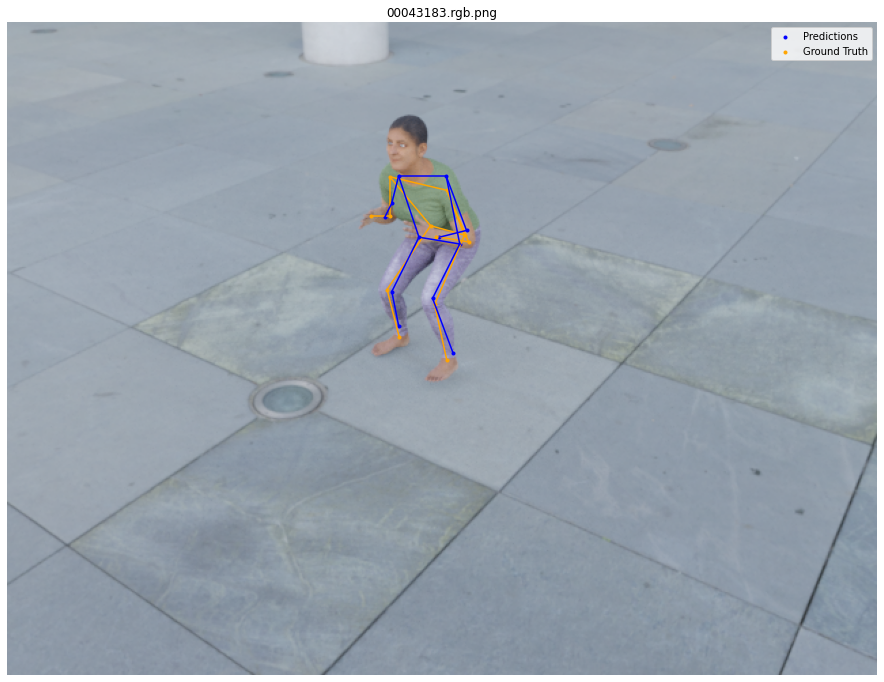

In [ ]:
path = '/content/drive/My Drive/231A Final Project/InfiniteForm/clean_dataset/'
filename = '00038168.rgb.png'

img = pimg.open(path + filename)
convert_tensor = transforms.ToTensor()
img_tensor = convert_tensor(img)

model = hg8(pretrained=True)
predictor = HumanPosePredictor(model, device='cuda')
joints = predictor.estimate_joints(img_tensor, flip=True).numpy()
pred = np.array([joints[13,:],joints[12,:],joints[14,:],joints[11,:],joints[15,:],joints[10,:],\
          joints[3,:],joints[2,:],joints[4,:],joints[1,:],joints[5,:],joints[0,:]])

gt = np.array(annot[str(int(filename.split('.')[0]))]['keypoints']).reshape(17,-1)[:,:-1]
visualize_infinite_form_format(pred, gt, path + filename)

# Testing different sizes of person in image

In [ ]:
all_proportions = []
for img_name in tqdm(files_to_analyze[:250]):
  person_area = annot[str(int(img_name.split(".")[0]))]['area']
  img_area = WIDTH * HEIGHT
  proportion = person_area / img_area
  all_proportions.append(proportion)

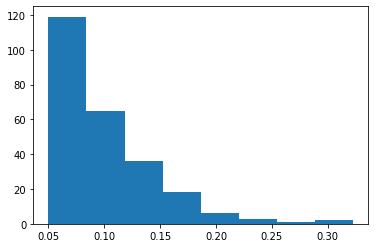

In [ ]:
plt.hist(all_proportions, bins=8)
plt.savefig('person_to_image_proportions.png', dpi=200)

In [ ]:
prop_scores = {"0.05_to_0.075": [], "0.075_to_0.10": [], "0.1_and_up": []}

for img_idx, img_name in enumerate(files_to_analyze[:250]):
  person_area = annot[str(int(img_name.split(".")[0]))]['area']
  img_area = WIDTH * HEIGHT
  proportion = person_area / img_area

  if proportion < 0.075:
    key = "0.05_to_0.075"
  elif proportion < 0.10:
    key = "0.075_to_0.10"
  else:
    key = "0.1_and_up"
  prop_scores[key].append(np.mean(pcks_8[img_idx]))

In [ ]:
for k,v in prop_scores.items():
  print(k, len(v), np.mean(v))

In [ ]:
prop_scores = {"0.05_to_0.075": [], "0.075_to_0.10": [], "0.1_and_up": []}

for img_idx, img_name in enumerate(files_to_analyze[:250]):
  person_area = annot[str(int(img_name.split(".")[0]))]['area']
  img_area = WIDTH * HEIGHT
  proportion = person_area / img_area

  if proportion < 0.075:
    key = "0.05_to_0.075"
  elif proportion < 0.10:
    key = "0.075_to_0.10"
  else:
    key = "0.1_and_up"
  prop_scores[key].append(np.mean(pcks_2[img_idx]))

In [ ]:
for k,v in prop_scores.items():
  print(k, len(v), np.mean(v))